## 1. Set-up

### 1.1 Imports

In [617]:
# Imports
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
import math

### 1.2 Helper Functions

In [618]:
# Encoding and decoding
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)
    
    if threshold > -1:
        with open(file_name,'rt', encoding='utf8') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt', encoding='utf8') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

def plot_data(x, y, xlabel, ylabel):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### 1.3 Device

In [619]:
# CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

## 2. Data-Preprocessing

### 2.1 Creating DataFrame

In [620]:
def create_df(bios, targets):
    zipped_data = list(zip(bios, targets))
    text_df = pd.DataFrame(zipped_data, columns=['Bios', 'Labels'])
    return text_df

### 2.2 Preprocessing Function

In [621]:
# Preprocessing
def process_data(data, words):
    fake_i = (data == words["[FAKE]"][0])
    real_i = (data == words["[REAL]"][0])
    target_indices = (fake_i + real_i).nonzero()
    num_entries = len(target_indices)
    bio_tensor_list = []
    target_list = []
    entry = 0
    start_i = 0

    while entry < num_entries:
        target_i = target_indices[entry]

        # Size of data and targets
        #print(f"Data size: {data[start_i:target_i].size()}")
        #print(f"Target size: {data[target_i].size()}")

        # Take in a list of tensors and use pad sequence
        bio = data[start_i:target_i]
        target = [1, 0] if data[target_i] == 122 else [0, 1]

        bio_tensor_list.append(torch.tensor(bio).squeeze())
        target_list.append(target)

        start_i = target_i + 1
        entry += 1

    # have largest size be 880
    pad_bias = torch.ones(880)
    bio_tensor_list.append(pad_bias)

    padded_bios = torch.t(pad_sequence(bio_tensor_list))
    padded_bios = padded_bios[:-1]
    targets = torch.tensor(target_list)

    # print("First bio", padded_bios[0].size())
    # print("Second bio", padded_bios[1].size())
    data_df = create_df(padded_bios, targets)
    return data_df

### 2.3 Dataset Class

In [622]:
class TextDataset(Dataset):
    def __init__(self, data_df):
        self.text_df = data_df
        print("Head of Data", self.text_df.head())
        self.x = self.text_df['Bios']
        self.y = self.text_df['Labels']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## 3. Models

### 3.1 FFNN

In [623]:
# FeedForward Model
class FFNN(nn.Module):
    def __init__(self, vocab, words, d_model, d_hidden, dropout):
        super().__init__() 
    
        # Class parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.d_model = d_model
        self.d_hidden = d_hidden
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout)

        # Embedding Layer
        self.embeds = nn.Embedding(self.vocab_size, self.d_model)

        # Linear Layers
        self.fc1 = nn.Linear(880 * d_model, d_hidden)
        self.fc2 = nn.Linear(d_hidden, 2)

        # Nonlinear Layer
        self.activation = nn.Tanh()

        # Setting weights
        self.init_weights()
                
    # Initialize weights for foward layer
    def init_weights(self):
        weight_range = 0.1
        self.embeds.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.bias.data.zero_()

    # Forward
    def forward(self, src):
        # Embeddings are fed into the forward layer
        embeds = self.embeds(src).view((-1, 880 * self.d_model))
        x = self.dropout(self.activation(self.fc1(embeds)))
        x = self.fc2(x)

        return x

### 3.2 LSTM

In [624]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self,vocab,words,d_model,d_hidden,n_layers,dropout_rate):
        super().__init__()
        
        # Class Parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.n_layers = n_layers
        self.d_hidden = d_hidden
        self.d_model = d_model

        # Embedding Layer
        self.embeds = nn.Embedding(self.vocab_size,self.d_model)
        
    # Forward
    def forward(self,src,h):
        embeds = self.dropout(self.embeds(src))       
        return [preds,h]
    
    def init_weights(self):
        pass        
    
    def detach_hidden(self, hidden):
        return [hidden, cell]

## 4. Training

In [625]:
def get_accuracy(preds, truth):
    preds, truth = np.array(preds), np.array(truth)
    acc_arr = preds == truth
    return np.sum(acc_arr) / len(acc_arr)

### 4.1 Train One Epoch

In [626]:
# Train Model Function
def train_model(model, train_data_loader, optimizer, criterion):
        #print(data.size())
        cur_loss = 0
        cur_acc = 0
        num_batches = len(train_data_loader)
        
        for batch_idx, (train_features, train_labels) in enumerate(train_data_loader):
            optimizer.zero_grad()
            # print(f"Train Features: {train_features[0]}")
            logit_output = model(train_features)
            probs = torch.softmax(logit_output, dim=1)
            loss = criterion(probs.float(), train_labels.float())
            preds = torch.argmax(logit_output, dim=1)
            truth = torch.argmax(train_labels, dim=1)
            # print(f"Logit Output = {logit_output}")
            # print(f"Probs = {probs}; Preds = {preds}\nLabels = {train_labels}; Truth = {truth}\n")

            acc = get_accuracy(preds, truth)

            loss.backward()
            optimizer.step()

            cur_loss += loss.item()
            cur_acc += acc

        # Shapes of output and targets
        # print(f"Output size: {probs.size()}")
        # print(f"Target size: {train_labels.size()}")

        # loss = F.mse_loss(output.float(), targets.float())
        # output = torch.argmax(output, dim=1)

        av_loss = cur_loss / num_batches
        av_acc = cur_acc / num_batches
        return av_loss, av_acc

### 4.2 Training over Epochs

In [627]:
def train_loop(model, data_df, epochs, optimizer, criterion):

    data = TextDataset(data_df)
    train_dataloader = DataLoader(data, batch_size=4000, shuffle=True)
    average_loss_list = []
    average_perp_list = []
    average_acc_list = []
    epoch_list = []
    
    for epoch in range(0, epochs):
        model.train(True)
        average_loss, average_accuracy = train_model(model, train_dataloader, optimizer, criterion)
        average_perplexity = math.exp(average_loss)
        model.train(False)

        average_loss_list.append(average_loss)
        average_perp_list.append(average_perplexity)
        average_acc_list.append(average_accuracy)
        epoch_list.append(epoch)
    
        print(f"At Epoch {epoch}, Accuracy = {average_accuracy} & Loss = {average_loss}")

    plot_data(epoch_list, average_loss_list, 'Epoch', 'Loss')
    plot_data(epoch_list, average_perp_list, 'Epoch', 'Perplexity')
    plot_data(epoch_list, average_acc_list, 'Epoch', 'Accuracy')

## 5. Testing Code

In [628]:
def test_model(model, df):
    data = TextDataset(df)
    dataloader = DataLoader(data, batch_size=len(df), shuffle=True)

    for batch_idx, (features, labels) in enumerate(dataloader):
        print(features.size())
        outputs = model(features).squeeze()
        outputs = torch.softmax(outputs, dim=1)
        outputs = torch.argmax(outputs, dim=1)
        truth = torch.argmax(labels, dim=1)

        acc = get_accuracy(truth, outputs)

 
    print("THING WEFRY JU SAYS HI")
    return acc

## 5. Running Code

### 5.1 Loading Parameters

In [629]:
class Params:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
            
model_map = {0: 'FFNN', 1: 'LSTM', 2: 'FFNN_CLASSIFY', 3: 'LSTM_CLASSIFY'}
train_map = {0: 'data/real.train.tok', 1: 'data/fake.train.tok', 2: 'data/mix.train.tok'}
valid_map = {0: 'data/real.valid.tok', 1: 'data/fake.valid.tok', 2: 'data/mix.valid.tok'}
test_map = {0: 'data/real.test.tok', 1: 'data/fake.test.tok', 2: 'data/mix.test.tok', 3: 'data/blind.test.tok'}

model_type = model_map[2]
# train_type = [train_map[0], train_map[1]]

# Types of data
train_type = train_map[2]
valid_type = valid_map[2]
test_type = test_map[0]

args = {
    "d_model": 12,
    "d_hidden": 12,
    "n_layers": 3,
    "batch_size": 20,
    "seq_len": 30,
    "printevery": 5000,
    "window": 3,
    "epochs": 20,
    "lr": 0.0001,
    "dropout": 0.35,
    "clip": 2.0,
    "model": model_type,
    "savename": model_type.lower(),
    "loadname": model_type.lower(),
    "trainname": train_type,
    "validname": valid_type,
    "testname": test_type
}

### 5.2 Main Function

In [630]:
# Main Function
def main(args): 
    torch.manual_seed(0)
    
    params = Params(**args)
    train_name = params.trainname
    valid_name = params.validname
    test_name = params.testname
    model_type = params.model
    d_mod = params.d_model
    d_hid = params.d_hidden
    dropout = params.dropout
    epochs = params.epochs

    # real, fake = params.trainname
    # [vocab_real, words_real, train_real] = read_encode(real, [], {}, [], 3)
    # [vocab_fake, words_fake, train_fake] = read_encode(fake, [], {}, [], 3)

    # train_features = torch.cat((torch.tensor(train_real), torch.tensor(train_fake)))
    # train_labels = torch.cat((torch.ones(len(train_real)), torch.zeros(len(train_fake))))
    # print(f'train_features: {train_features}')
    # print(f'train_labels: {train_labels}')

    [vocab,words,train] = read_encode(train_name,[],{},[],3)
    train_data = torch.tensor(train)

    [valid_vocab,valid_words,valid] = read_encode(valid_name,[],{},[],3)
    valid_data = torch.tensor(valid)
    
    # print('vocab: %d train: %d' % (len(vocab),len(train)))
    # print(f'vocab: {vocab[10:20]}\n \n train: {train[10:20]}')
    print(f'fake id: {words["[FAKE]"]}')
    print(f'real id: {words["[REAL]"]}')

    # [vocab,words,test] = read_encode(test_name,vocab,words,[],-1)
    # test_data = torch.tensor(test)

    #print('vocab: %d test: %d' % (len(vocab),len(test)))

    vocab_size = len(vocab)
    train_df = process_data(train_data, words)
    validation_df = process_data(valid_data, valid_words)
    #test_df = process_data(test_data, test_name)
    
    if model_type == 'FFNN':
        ffnn_model = FFNN(vocab, words, d_mod, d_hid, dropout)
        ffnn_model.to(device)
        optimizer = torch.optim.SGD(ffnn_model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.BCELoss()
        train_loop(ffnn_model, train_df, epochs, optimizer, criterion)
        # print(ffnn_model)
#          {add code to instantiate the model, train for K epochs and save model to disk}
        
    if model_type == 'LSTM':
        pass
#          {add code to instantiate the model, train for K epochs and save model to disk}

    if model_type == 'FFNN_CLASSIFY':
        ffnn_model = FFNN(vocab, words, d_mod, d_hid, dropout)
        ffnn_model.to(device)
        optimizer = torch.optim.SGD(ffnn_model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.BCELoss()
        train_loop(ffnn_model, train_df, epochs, optimizer, criterion)


        acc = test_model(ffnn_model, validation_df)
        print(acc)
        
#          {add code to instantiate the model, recall model parameters and perform/learn classification}    

    if model_type == 'LSTM_CLASSIFY':
        pass
#          {add code to instantiate the model, recall model parameters and perform/learn classification}


### 5.3 Running Main Function

fake id: [122, 3913]
real id: [635, 4049]


/var/folders/df/1dzm_vq92djgwxktrkqptf7r0000gn/T/ipykernel_72567/2191483302.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_tensor_list.append(torch.tensor(bio).squeeze())
/var/folders/df/1dzm_vq92djgwxktrkqptf7r0000gn/T/ipykernel_72567/2191483302.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_tensor_list.append(torch.tensor(bio).squeeze())


Head of Data                                                 Bios                  Labels
0  [tensor(1), tensor(2), tensor(3), tensor(4), t...  [tensor(1), tensor(0)]
1  [tensor(1), tensor(2), tensor(3), tensor(4), t...  [tensor(1), tensor(0)]
2  [tensor(1), tensor(2), tensor(3), tensor(4), t...  [tensor(1), tensor(0)]
3  [tensor(1), tensor(2), tensor(3), tensor(4), t...  [tensor(1), tensor(0)]
4  [tensor(93), tensor(1), tensor(2), tensor(3), ...  [tensor(0), tensor(1)]
At Epoch 0, Accuracy = 0.5083977788995457 & Loss = 0.778319776058197
At Epoch 1, Accuracy = 0.5078039500252398 & Loss = 0.7549173831939697
At Epoch 2, Accuracy = 0.5055479555779909 & Loss = 0.7282210290431976
At Epoch 3, Accuracy = 0.49183783442705703 & Loss = 0.7096346914768219
At Epoch 4, Accuracy = 0.49626558556284706 & Loss = 0.7020054459571838
At Epoch 5, Accuracy = 0.49674160777385157 & Loss = 0.7006352245807648
At Epoch 6, Accuracy = 0.507791961130742 & Loss = 0.6972322762012482
At Epoch 7, Accuracy = 0.515726905

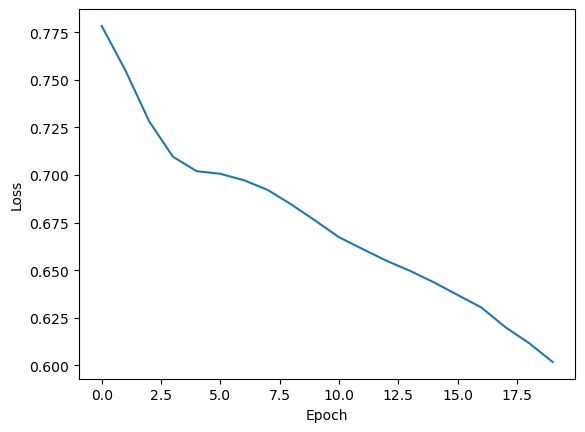

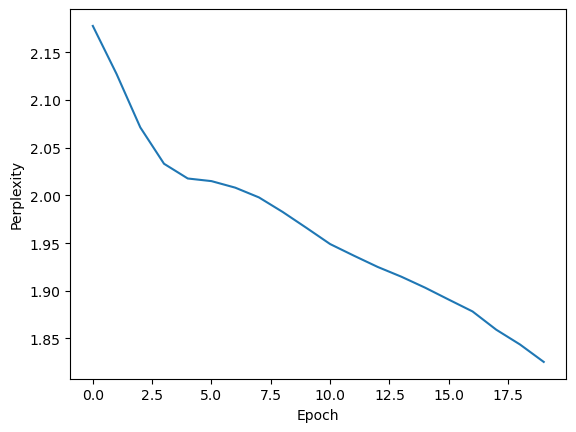

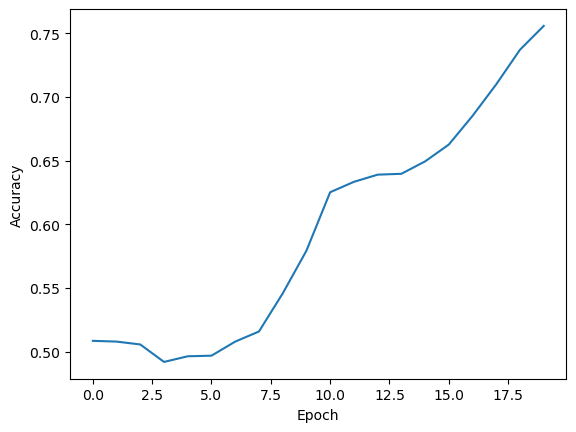

Head of Data                                                 Bios                  Labels
0  [tensor(1), tensor(2), tensor(3), tensor(4), t...  [tensor(0), tensor(1)]
1  [tensor(34), tensor(1), tensor(2), tensor(3), ...  [tensor(0), tensor(1)]
2  [tensor(34), tensor(1), tensor(2), tensor(3), ...  [tensor(0), tensor(1)]
3  [tensor(1), tensor(2), tensor(3), tensor(4), t...  [tensor(0), tensor(1)]
4  [tensor(1), tensor(2), tensor(3), tensor(4), t...  [tensor(0), tensor(1)]
torch.Size([986, 880])
THING WEFRY JU SAYS HI
0.6105476673427992


In [631]:
main(args)